In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from dataset import load_dataset
from models import ALEXNET, VGGNET, LENET

def show_result(images, labels, test_pred, i, function) :
    plt.imshow(images[i], interpolation='nearest')
    plt.axis('off')
    plt.show()

    target = np.argmax(labels[i])
    pred = np.argmax(test_pred[i])
    
    if function == 'count' :
        if target == 11:
            print("Prediction: More than 10 items")
        else :
            #print("Prediction: %d items by %.2f percent" % (pred, (test_pred[i][pred])*100))
            print("Prediction: %d items" % pred)
    
        if target == 11:
            print("Target: More than 10 items")
        else :
            print("Target: " + str(target) + " items")

    else :
        #print("Prediction: item number %d by %.2f percent" % (pred, (test_pred[i][pred])*100))
        print("Prediction: item number %d" % pred)
        print("Target: item number " + str(target))

def test(model, sess, saver, test_data, function, difficulty, batch_size):
    """
    Tester
    """
    batch_image, batch_image_index = test_data.get_batch_tensor(batch_size=batch_size)

    with tf.Session() as _sess:
        _sess.run(tf.local_variables_initializer())
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess=_sess, coord=coord)
        final_test_metric = 0
        batch_cnt = 0
        true_cnt, false_cnt = 0, 0 
        true_zero_cnt, true_one_cnt, true_two_cnt = 0, 0, 0
        false_zero_cnt, false_one_cnt, false_two_cnt = 0, 0, 0
        
        try:
            while not coord.should_stop():
                images, indices = _sess.run([batch_image, batch_image_index])
                labels = test_data.get_labels_from_indices(indices, function, difficulty)
                test_metric, test_pred, test_pred_one = model.eval_metric(images, labels)
                final_test_metric = final_test_metric + test_metric
                batch_cnt = batch_cnt + 1
                
                if (true_cnt < 4) and (false_cnt < 4) :
                    for b in range(batch_size) :
                        target = np.argmax(labels[b])
                        pred = np.argmax(test_pred[b])

                        if function == 'count' :
                            if (target == pred) and (true_cnt < 3) :
                                if (target == 0) and (true_zero_cnt == 0) :
                                    true_zero_cnt = 1
                                    show_result(images, labels, test_pred, b, function)
                                    true_cnt = true_cnt + 1
                                elif (target == 1) and (true_one_cnt == 0) :
                                    true_one_cnt = 1
                                    show_result(images, labels, test_pred, b, function)
                                    true_cnt = true_cnt + 1
                                elif (target == 2) and (true_two_cnt == 0) :
                                    true_two_cnt = 1
                                    show_result(images, labels, test_pred, b, function)
                                    true_cnt = true_cnt + 1
                                elif (target != 0) and (target != 1) and (target != 2) :
                                    show_result(images, labels, test_pred, b, function)
                                    true_cnt = true_cnt + 1

                            elif (target != pred) and (false_cnt < 3) :
                                if (target == 0) and (false_zero_cnt == 0) :
                                    false_zero_cnt = 1
                                    show_result(images, labels, test_pred, b, function)
                                    false_cnt = false_cnt + 1
                                elif (target == 1) and (false_one_cnt == 0) :
                                    false_one_cnt = 1
                                    show_result(images, labels, test_pred, b, function)
                                    false_cnt = false_cnt + 1
                                elif (target == 2) and (false_two_cnt == 0) :
                                    false_two_cnt = 1
                                    show_result(images, labels, test_pred, b, function)
                                    false_cnt = false_cnt + 1
                                elif (target != 0) and (target != 1) and (target != 2):
                                    show_result(images, labels, test_pred, b, function)
                                    false_cnt = false_cnt + 1
                        else :
                            if (target == pred) and (true_cnt < 3) :
                                show_result(images, labels, test_pred, b, function)
                                true_cnt = true_cnt + 1
                            elif (target != pred) and (false_cnt < 3) :
                                show_result(images, labels, test_pred, b, function)
                                false_cnt = false_cnt + 1
                
        except tf.errors.OutOfRangeError:
            print('final test accuracy : %.4f' % (final_test_metric/batch_cnt))
            print('Done testing -- epoch limit reached')
        finally:
            coord.request_stop()
            coord.join(threads)               
                
def run(model_name, function, difficulty, batch_size, model_filename, learning_rate = 0.00005) :
    with tf.Session() as sess:
            # Define computation graph & Initialize
            print('Building network & initializing variables')
            if model_name == 'ALEXNET':
                model = ALEXNET(function, learning_rate, difficulty, model_filename)
            elif model_name == 'VGGNET':
                model = VGGNET(function, learning_rate, difficulty, model_filename)
            else:
                model = LENET(function, learning_rate, difficulty, model_filename)

            model.init_sess(sess)
            saver = tf.train.Saver()

            # Process data
            print("Load dataset")
            dataset = load_dataset()
            test_data = dataset.test

            print('Loading best checkpointed model')
            saver.restore(sess, "../"+model.model_filename)
            test(model, sess, saver, test_data, function, difficulty, batch_size)

Building network & initializing variables
Load dataset
Loading best checkpointed model
INFO:tensorflow:Restoring parameters from ../model/VGG_count_moderate_68.ckpt
load dataset for test
use filename format /Users/Ji-Eun/Desktop/2017-2/Creative/mxnet-amznbin/dataset/test_*.tfrecords
is_training == False : FIFOQueue
Tensor("shuffle_batch:0", shape=(10, 224, 224, 3), dtype=uint8)
Tensor("shuffle_batch:1", shape=(10,), dtype=int64)


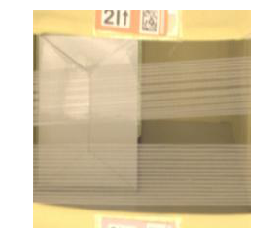

Prediction: 1 items
Target: 1 items


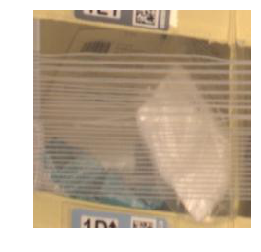

Prediction: 1 items
Target: 2 items


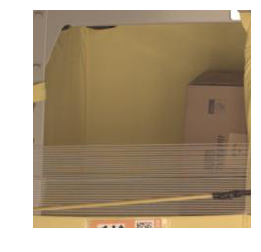

Prediction: 0 items
Target: 1 items


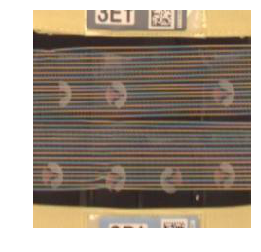

Prediction: 1 items
Target: 7 items


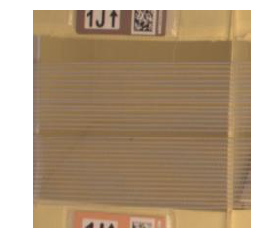

Prediction: 0 items
Target: 0 items


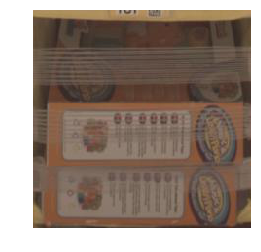

Prediction: 2 items
Target: 2 items
final test accuracy : 68.5714
Done testing -- epoch limit reached


In [2]:
run("VGGNET", "count", "moderate", 10, "VGG_count_moderate_68")
# run("VGGNET", "classify", "hard", 10, "VGG_classify_hard_41")